# Regional Influence

Hypothesis: <b>
UFO sightings are more prevalent in countries with higher Netflix usage after the release of alien films.
	


In [3]:
import sys
import os
# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))



In [4]:
from setup.helper.sql_engine import get_engine
from sqlalchemy import text
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [5]:
# Get the engine
engine = get_engine()

In [ ]:
with engine.connect() as connection:
    connection.execute(text("USE ufo_sightings;"))
    result = connection.execute(text("""
        with sightings_per_country as(
select country_id, count(country_id) as sightings_count
from ufo_sightings 
WHERE year(date) = 2022 -- using 2022 as baseline as last year with complete observations in dataset
Group by country_id),
max_sightings AS (
    SELECT MAX(sightings_count / population)*1000 AS max_sightings_per_capita
	from countries c
    JOIN sightings_per_country u USING (country_id)
)
select c.country_id, c.country, s.subscribers, c.population, round(s.subscribers/c.population*100,2) as pentration, u.sightings_count,
sightings_count/population*1000/(select max_sightings_per_capita from max_sightings) as sightings_per_capita_normalised
from subscribers s
JOIN countries c
USING (country_id)
JOIN sightings_per_country u
USING (country_id)
WHERE country_id IN (select DISTINCT country_id FROM ufo_sightings)
ORDER by sightings_per_capita_normalised DESC;"""))
    df = pd.DataFrame(result.all())
    df["pentration"] = df["pentration"].astype(float)
    df["sightings_per_capita_normalised"] = round(df["sightings_per_capita_normalised"].astype(float),3)

In [ ]:

# Add a constant for the intercept
X = sm.add_constant(df["pentration"])

# Fit Model
model = sm.OLS(df["sightings_count"], X).fit()
print(model.summary())

In [ ]:
# Customize the plot
plt.figure(figsize=(12, 8))  # Set the figure size
sns.set_style("white")  # Set the style of the plot
sns.regplot(data=df, x="pentration", y="sightings_per_capita_normalised", color="blue", marker="o")

# Add labels and title
plt.title("Relationship Between Netflix Penetration and UFO Sightings (Normalized)", fontsize=16)
plt.xlabel("Netflix Penetration (%)", fontsize=14)
plt.ylabel("Normalized UFO Sightings Per Capita", fontsize=14)

# Adjust tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



                            OLS Regression Results                            
Dep. Variable:        sightings_count   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.625
Date:                Fri, 28 Mar 2025   Prob (F-statistic):              0.114
Time:                        19:16:16   Log-Likelihood:                -293.63
No. Observations:                  37   AIC:                             591.3
Df Residuals:                      35   BIC:                             594.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -99.0979    182.218     -0.544      

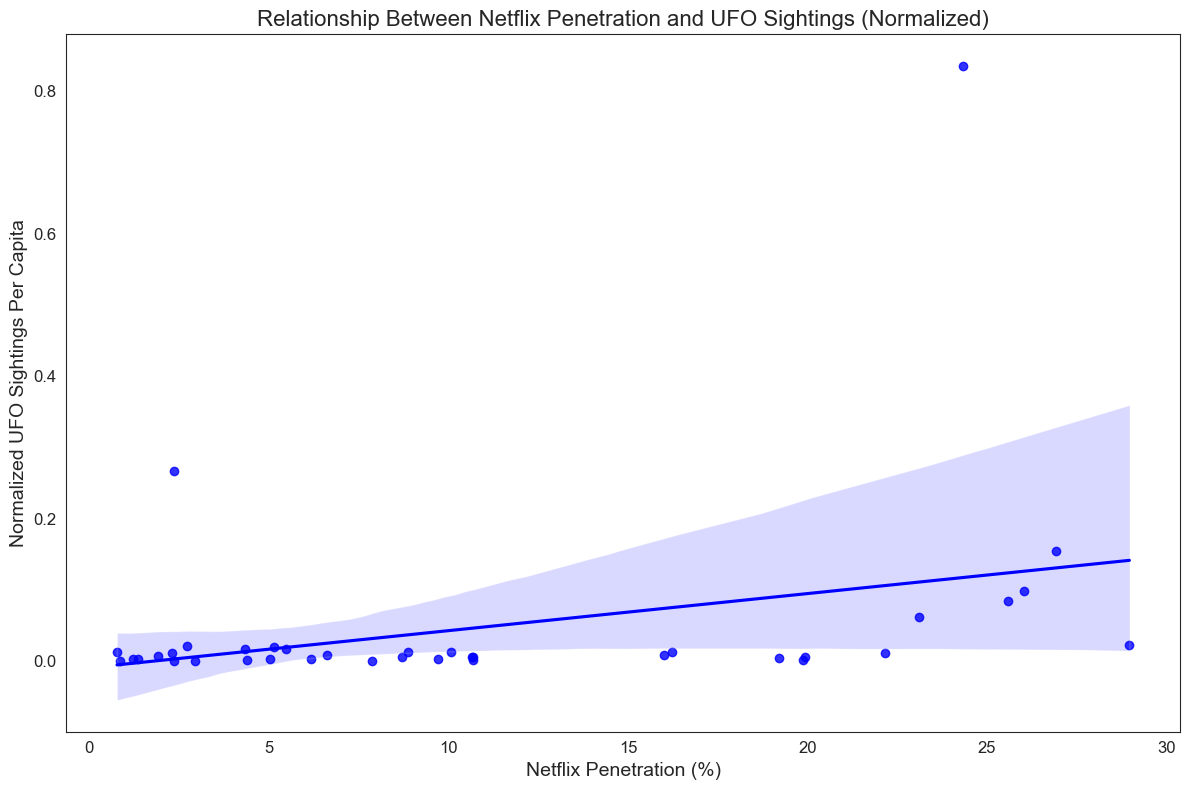

In [6]:
# regional_influence.py
import sys
import os
from setup.helper.sql_engine import get_engine
from sqlalchemy import text
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Function to execute the SQL query and fetch data
def get_ufo_data():
    # Get the engine
    engine = get_engine()
    with engine.connect() as connection:
        connection.execute(text("USE ufo_sightings;"))
        result = connection.execute(text("""
            WITH sightings_per_country AS (
                SELECT country_id, COUNT(country_id) AS sightings_count
                FROM ufo_sightings 
                WHERE YEAR(date) = 2022 -- using 2022 as baseline as last year with complete observations in dataset
                GROUP BY country_id
            ),
            max_sightings AS (
                SELECT MAX(sightings_count / population) * 1000 AS max_sightings_per_capita
                FROM countries c
                JOIN sightings_per_country u USING (country_id)
            )
            SELECT c.country_id, c.country, s.subscribers, c.population, 
                   ROUND(s.subscribers/c.population * 100, 2) AS penetration, 
                   u.sightings_count,
                   sightings_count/population * 1000 / (SELECT max_sightings_per_capita FROM max_sightings) AS sightings_per_capita_normalised
            FROM subscribers s
            JOIN countries c USING (country_id)
            JOIN sightings_per_country u USING (country_id)
            WHERE country_id IN (SELECT DISTINCT country_id FROM ufo_sightings)
            ORDER BY sightings_per_capita_normalised DESC;
        """))
        df = pd.DataFrame(result.all())
        df["penetration"] = df["penetration"].astype(float)
        df["sightings_per_capita_normalised"] = round(df["sightings_per_capita_normalised"].astype(float), 3)
    return df

# Function to perform regression analysis
def perform_regression_analysis(df):
    # Add a constant for the intercept
    X = sm.add_constant(df["penetration"])
    
    # Fit the OLS model
    model = sm.OLS(df["sightings_count"], X).fit()
    print(model.summary())
    
    return model

# Function to plot the relationship between Netflix penetration and UFO sightings
def plot_relationship(df):
    # Customize the plot
    plt.figure(figsize=(12, 8))  # Set the figure size
    sns.set_style("white")  # Set the style of the plot
    sns.regplot(data=df, x="penetration", y="sightings_per_capita_normalised", color="blue", marker="o")

    # Add labels and title
    plt.title("Relationship Between Netflix Penetration and UFO Sightings (Normalized)", fontsize=16)
    plt.xlabel("Netflix Penetration (%)", fontsize=14)
    plt.ylabel("Normalized UFO Sightings Per Capita", fontsize=14)

    # Adjust tick parameters
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Main function to execute the analysis
def main():

    # Get the UFO data
    df = get_ufo_data()
    
    # Perform the regression analysis
    perform_regression_analysis(df)
    
    # Plot the relationship
    plot_relationship(df)

if __name__ == "__main__":
    main()
